In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
import tensorflow_datasets as tfds
from time import time
import matplotlib.pyplot as plt 
tf.config.run_functions_eagerly(True)

In [13]:

def zero_mask(shape, zero_indices):
    """
    inputs:
        shape: shape of matrix, ei (channels, filters, kernals, x_dims, y_dims)
        zero_indices: list of tuples that specify indexes to be masked to 0, ei [(row, col, channel, filter)]
            if zero_indices is equal to [(r, col, ch, f)] then mask[r, col, ch, f] will be set to 0
    instance variables
    """
    mask = np.ones(shape)
    for index in zero_indices:
        mask[index] = 0.
    return mask

In [14]:
def pattern_maker(filters, patterns, pattern_freq, kernel_size = (3,3)): #channels is limited to one here, make more robust 
    channel = 0
    assert filters == sum(pattern_freq)
    zero_indices = []
    filter_n = 0
    for pattern, freq in zip(patterns, pattern_freq):
        for i in range(kernel_size[0]):
            for j in range(kernel_size[1]):
                if pattern[i][j] == 0.:
                    for _ in range(freq):
                        zero_indices.append((i, j, channel, filter_n + _))
        filter_n += freq
        
    return zero_indices

patterns = [[[0, 1, 0], [0, 1, 1], [0, 1, 0]],
            [[0, 1, 0], [1, 1, 1], [0, 0, 0]], 
            [[0, 0, 0], [1, 1, 1], [0, 1, 0]],
            [[0, 1, 0], [1, 1, 0], [0, 1, 0]], 
            [[1, 0, 0], [1, 1, 0], [1, 0, 0]],
            [[1, 1, 0], [0, 1, 0], [0, 1, 0]],
            [[0, 0, 1], [0, 1, 1], [0, 0, 1]],
            [[1, 1, 1], [0, 1, 0], [0, 0, 0]],
           [[0, 0, 0], [0, 1, 0], [1, 1, 1]],
           [[0, 0, 1], [0, 1, 0], [1, 0, 1]]]
pattern_freq = [4]*10
zero_indices = pattern_maker(4*10, patterns, pattern_freq)
mask = zero_mask(shape = (3, 3, 1, 40), zero_indices = zero_indices)


In [15]:
batch_size = 64
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

C:\Users\14135\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [16]:

"""
@tf.custom_gradient
def conv2d_override(x, filters, strides, padding, data_format='NHWC', dilations=None, name=None):
    y, f = tf.nn.conv2d(x, filters, strides, padding) #, data_format, dilations, name)
    def grad(upstream):
        grads = f(upstream)
        return grads # .multiply(grads, self.zero_mask)
    return y, grad
    """

class IregConv2D(tf.keras.layers.Layer): # still needs to figure out backprop, keep kernal wieghts at 0!!.
    def __init__(self, zero_mask, strides = 1, padding = "SAME", *args, **kwargs):
        super(IregConv2D, self).__init__()
        
        @tf.custom_gradient
        def conv2d_override(x, filters, strides, padding, data_format='NHWC', dilations=None, name=None):
            with tf.GradientTape() as tape:
                y = tf.nn.conv2d(x, filters, strides = 1, padding = "SAME", data_format='NHWC', dilations=None, name=None)
            def grad(upstream):
                dydx, grads = tape.gradient(y, [x, filters])
                return dydx, tf.multiply(grads, self.zero_mask), None, None
            return y, grad
        
        self.zero_mask = tf.cast(zero_mask, dtype = tf.float32)
        self.strides = strides
        self.padding = padding

        w_init = tf.keras.initializers.HeNormal()
        w = w_init(shape = zero_mask.shape, dtype = 'float32') #note the sloppy zero_mask.shape // change this
        #self.b = self.add_weight(shape = zero_mask.shape[2:], initializer="he_normal", trainable=True) # sloppy, change this 
        w = tf.multiply(self.zero_mask, w)
        self.w = tf.Variable(initial_value=w, trainable=True)
        self.conv = conv2d_override
    
    def call(self, x):
        return self.conv(x, self.w, self.strides, self.padding)
    def get_conv(self):
        return self.conv

In [17]:
class TestNet(tf.keras.Model):
    def __init__(self):
        super(TestNet, self).__init__()
        self.conv = IregConv2D(mask)
        self.relu1 = ReLU()
        self.flatten = Flatten()
        self.dense = Dense(32, activation = 'relu')
        self.head = Dense(10, activation = 'softmax')
        
    def call(self, x):
        x = self.conv(x)
        x = self.relu1(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.head(x)
        return x

In [18]:
class BaseNet(tf.keras.Model):
    def __init__(self):
        super(BaseNet, self).__init__()
        self.conv = Conv2D(filters = 40, kernel_size = (3, 3), activation = 'relu')
        self.flatten = Flatten()
        self.dense = Dense(32, activation = 'relu')
        self.head = Dense(10, activation = 'softmax')
    
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.head(x)
        return x

In [24]:
ireg_model = TestNet()
reg_model = BaseNet()
num_epochs = 10
lr = 0.001

In [25]:
ireg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[ tf.keras.metrics.SparseCategoricalAccuracy()])

ireg_history = ireg_model.fit(ds_train, epochs = num_epochs, validation_data = ds_test, verbose = 2)

Epoch 1/10


KeyboardInterrupt: 

In [10]:
reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[ tf.keras.metrics.SparseCategoricalAccuracy()])

reg_history = reg_model.fit(ds_train, epochs = num_epochs, validation_data = ds_test, verbose = 2)

Epoch 1/10
938/938 - 23s - loss: 0.1950 - sparse_categorical_accuracy: 0.9414 - val_loss: 0.0872 - val_sparse_categorical_accuracy: 0.9752
Epoch 2/10
938/938 - 18s - loss: 0.0634 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.0654 - val_sparse_categorical_accuracy: 0.9788
Epoch 3/10
938/938 - 17s - loss: 0.0406 - sparse_categorical_accuracy: 0.9873 - val_loss: 0.0576 - val_sparse_categorical_accuracy: 0.9823
Epoch 4/10
938/938 - 19s - loss: 0.0272 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.0608 - val_sparse_categorical_accuracy: 0.9803
Epoch 5/10
938/938 - 19s - loss: 0.0198 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.0654 - val_sparse_categorical_accuracy: 0.9812
Epoch 6/10
938/938 - 18s - loss: 0.0163 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.0641 - val_sparse_categorical_accuracy: 0.9803
Epoch 7/10
938/938 - 20s - loss: 0.0112 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0606 - val_sparse_categorical_accuracy: 0.9832
Epoch 8/10
938/938 - 20s - 

ireg_model.conv.w

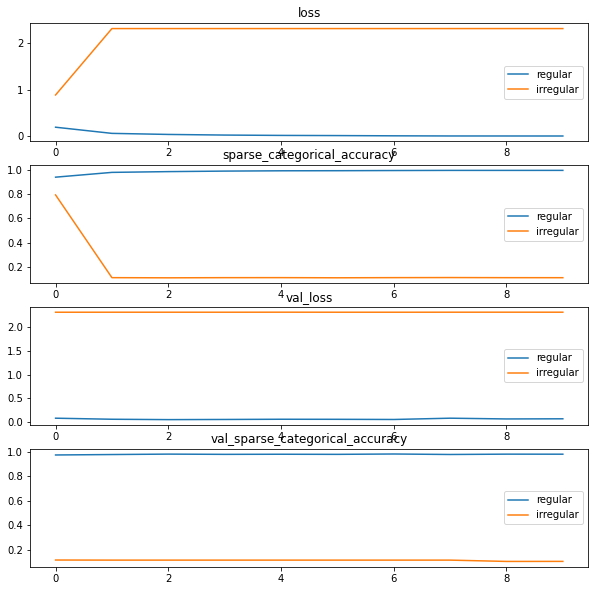

In [11]:
fig, axs = plt.subplots(4, 1, figsize = (10, 10))
for key, ax in zip(reg_history.history.keys(), axs):
    ax.plot(reg_history.history[key])
    ax.plot(ireg_history.history[key])
    ax.legend(['regular', 'irregular'])
    ax.set_title(key)